In [1]:
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.dataset as ds
import pyarrow.compute as pc
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
from multiprocessing import Pool
import json
from source import *
import matplotlib.pyplot as plt
import pyarrow.parquet as pq

import scienceplots

plt.style.use(['science','ieee', 'grid'])

In [2]:
dataset = ds.dataset([fr"sig_data/sig_{i}.parquet" for i in range(1, 22)], format="parquet")

In [3]:
scanner = dataset.scanner(batch_size=100_000)
for batch in scanner.to_batches():
    table = pa.Table.from_batches([batch])
    display(table.to_pandas().columns)
    break
del scanner

Index(['__experiment__', '__run__', '__event__', '__production__',
       '__candidate__', '__ncandidates__', '__weight__', 'N_KL', 'idec0',
       'idec1', 'totalEnergyMC', 'E_gamma_in_ROE', 'Bs_lik', 'is0',
       'Miss_id_0', 'Miss_id_1', 'missedE', 'M0', 'p0', 'recM2_Ups',
       'recM2_Bs', 'N_KS', 'p_tau_0', 'p_tau_1', 'tau_d_0_0', 'tau_d_1_0',
       'tau_last_z_0', 'tau_last_r_0', 'tau_last_z_1', 'tau_last_r_1',
       'correct_nu_0', 'correct_nu_1', 'correct_gamma_0', 'correct_gamma_1',
       'lost_0', 'lost_1', 'PID_self_vs_0_tau0', 'PID_self_vs_1_tau0',
       'PID_self_vs_2_tau0', 'PID_self_vs_4_tau0', 'PID_self_vs_0_tau1',
       'PID_self_vs_1_tau1', 'PID_self_vs_2_tau1', 'PID_self_vs_4_tau1'],
      dtype='object')

In [4]:
decay_mod_tau = ["$e^+ \\nu_e \\bar \\nu_\\tau$", "$\mu^+ \\nu_\\mu \\bar \\nu_\\tau$", "$\\pi^+ \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\pi^0) \\bar \\nu_\\tau$", "$\\pi^+ \\pi^+ \\pi^- \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\gamma) \\bar \\nu_\\tau$"]
mask = (pc.field("E_gamma_in_ROE") < 1.2) & (pc.field("Bs_lik") > 0.0012) 
mask_M = (pc.field("M0") > 5.347) &  (pc.field("M0") < 5.387) 
mask1 = (pc.field("E_gamma_in_ROE") < 1.2) & (pc.field("is0") == 1) & (pc.field("Bs_lik") > 0.0012) &  (pc.field("M0") > 5.347) &  (pc.field("M0") < 5.387) 
mask0 = (pc.field("E_gamma_in_ROE") < 1.2) & (pc.field("is0") == 0) & (pc.field("Bs_lik") > 0.0012) &  (pc.field("M0") > 5.347) &  (pc.field("M0") < 5.387)
mask_is1 = pc.field("correct_nu_0") & pc.field("correct_nu_1") & pc.field("correct_gamma_0") & pc.field("correct_gamma_1") & pc.field("lost_0") & pc.field("lost_1") & pc.field("Miss_id_0") & pc.field("Miss_id_1")
mask_is0 = pc.field("is0") == 1
mask_lep = ((pc.field("idec0") == 0) | (pc.field("idec0") == 1)) & ((pc.field("idec1") == 0) | (pc.field("idec1") == 1))

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_6729/511305829.py:1: SyntaxWarning: invalid escape sequence '\m'
  decay_mod_tau = ["$e^+ \\nu_e \\bar \\nu_\\tau$", "$\mu^+ \\nu_\\mu \\bar \\nu_\\tau$", "$\\pi^+ \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\pi^0) \\bar \\nu_\\tau$", "$\\pi^+ \\pi^+ \\pi^- \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\gamma) \\bar \\nu_\\tau$"]


In [5]:
decay_mod_tau = ["$e^+ \\nu_e \\bar \\nu_\\tau$", "$\mu^+ \\nu_\\mu \\bar \\nu_\\tau$", "$\\pi^+ \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\pi^0) \\bar \\nu_\\tau$", "$\\pi^+ \\pi^+ \\pi^- \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\gamma) \\bar \\nu_\\tau$"]

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_6729/1033810642.py:1: SyntaxWarning: invalid escape sequence '\m'
  decay_mod_tau = ["$e^+ \\nu_e \\bar \\nu_\\tau$", "$\mu^+ \\nu_\\mu \\bar \\nu_\\tau$", "$\\pi^+ \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\pi^0) \\bar \\nu_\\tau$", "$\\pi^+ \\pi^+ \\pi^- \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\gamma) \\bar \\nu_\\tau$"]


In [6]:
wbin = 0.05
a = 0
b = 1.2
bins = np.linspace(a, b, int((b-a)/wbin))

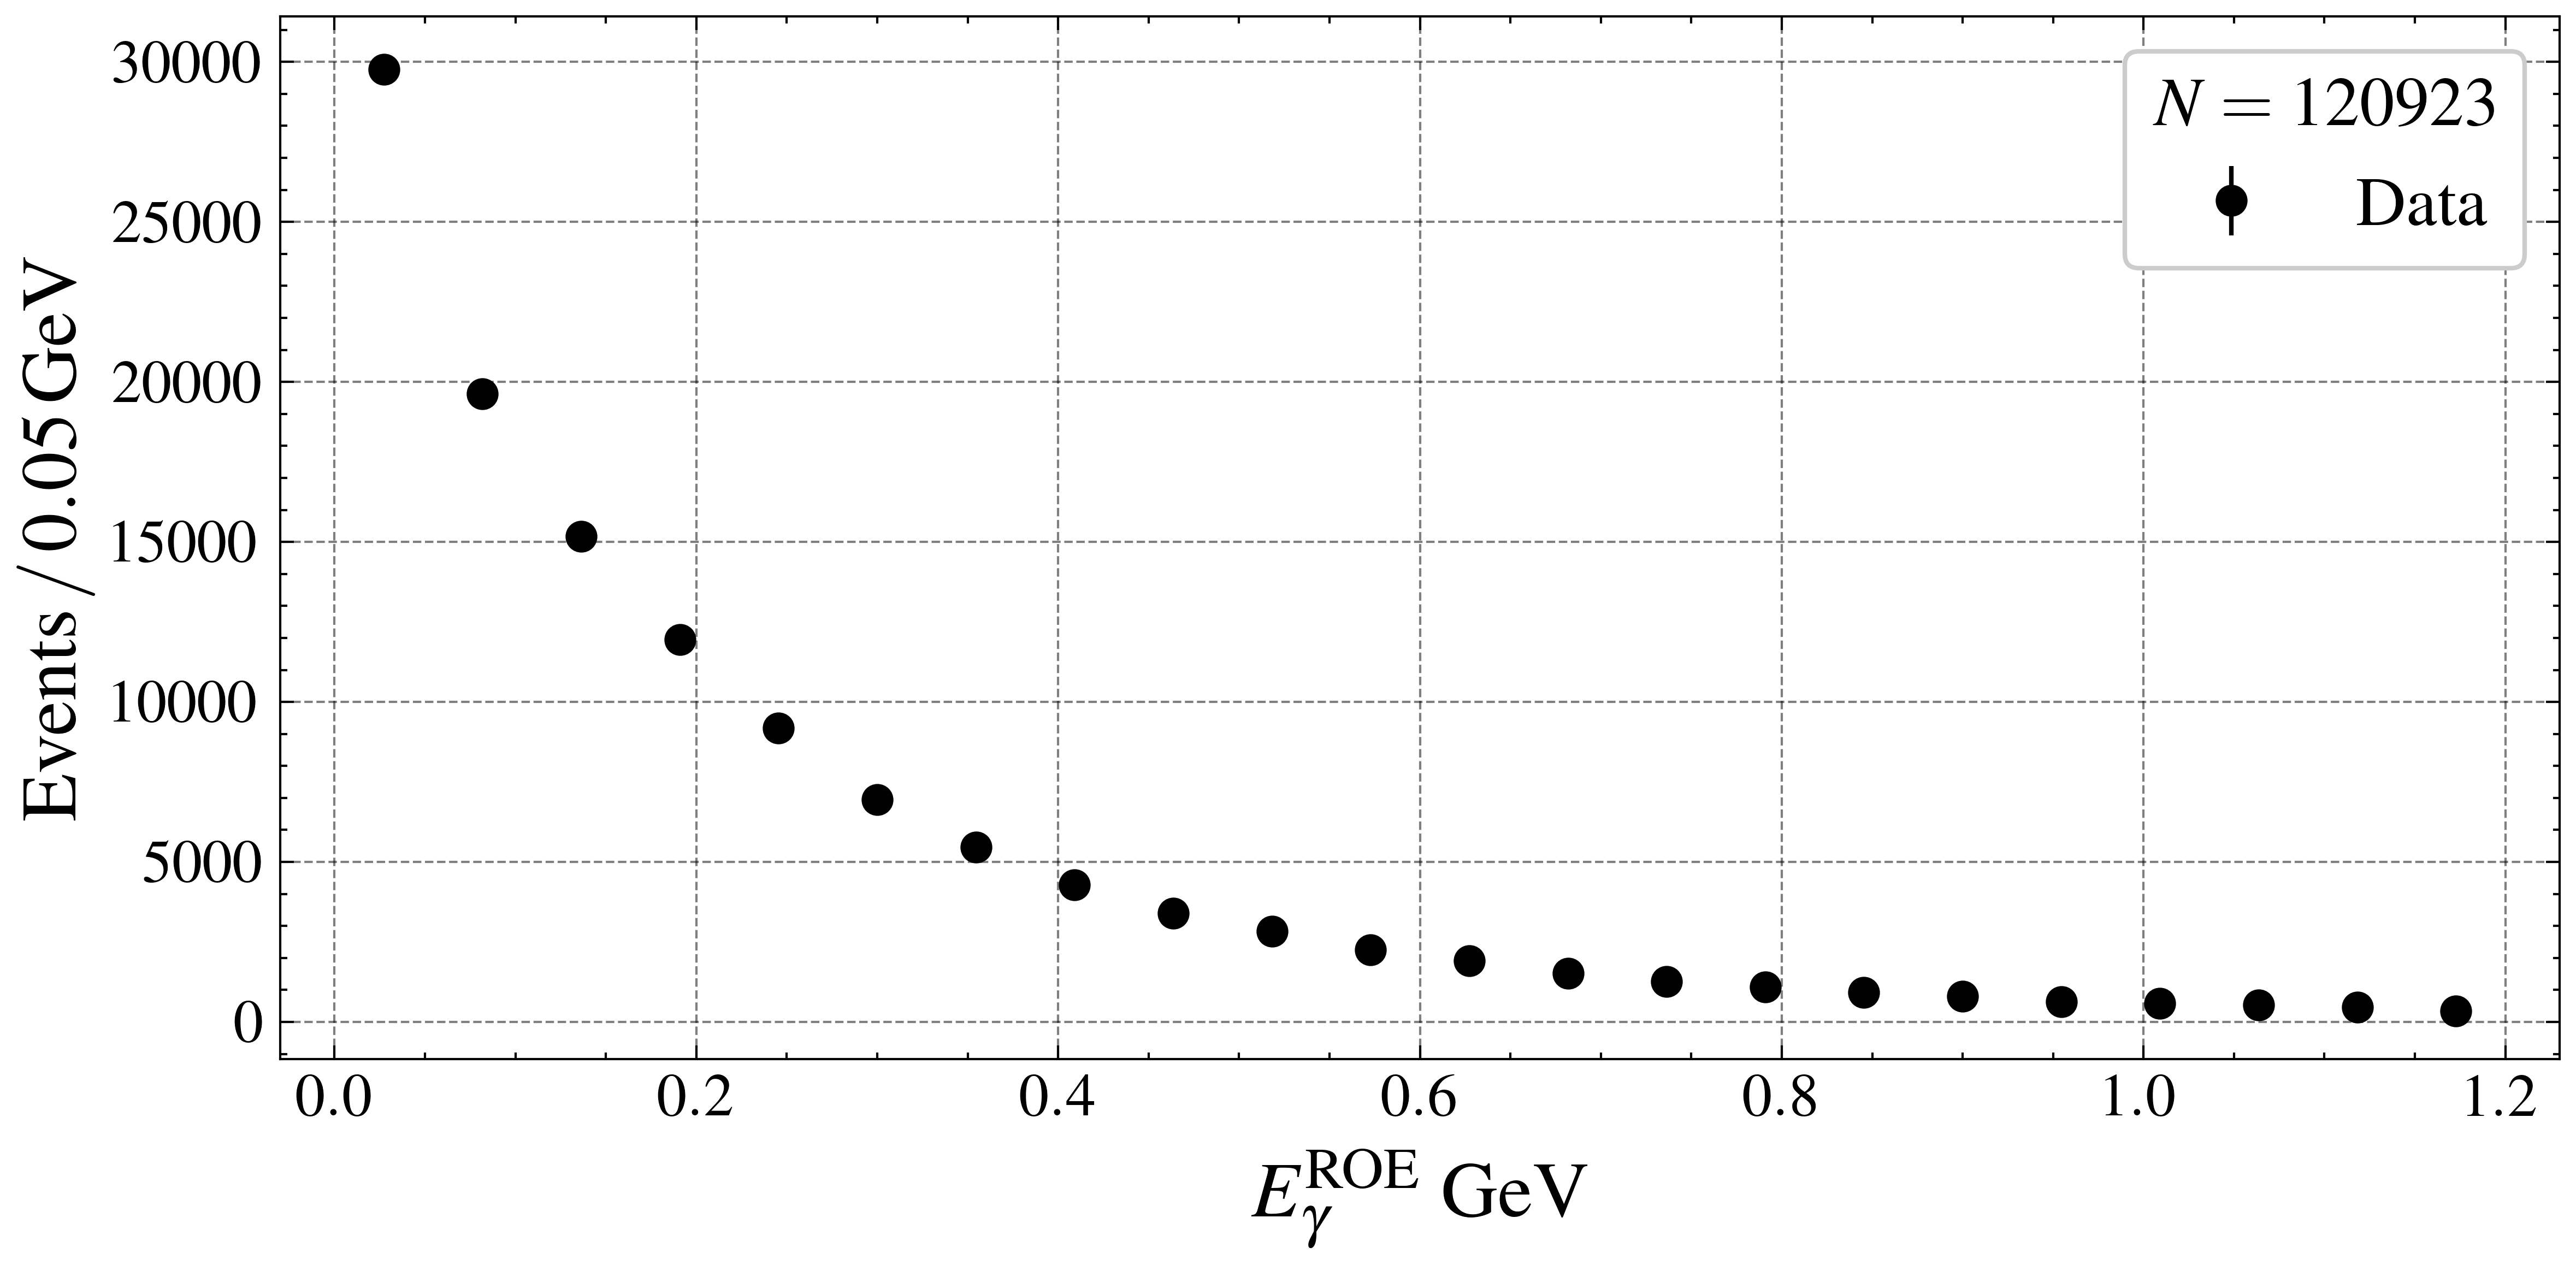

In [7]:
bin_centers, counts, N = compute_histogram(dataset, bins, "E_gamma_in_ROE", filter_mask= mask & mask_M & mask_is0 & mask_is1 & mask_lep)


fig, ax = plt.subplots(1, figsize=(12/1.5, 6/1.5))

ax.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='o', label="Data")
ax.set_ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}\\,\\mathrm{{GeV}}$')
ax.set_xlabel(r'$E_{\gamma}^\mathrm{ROE} \ \mathrm{GeV}$')
ax.set_title("")
ax.legend(title=f"$N = {N}$")

plt.tight_layout()
plt.show()

In [8]:
@njit(fastmath=True)
def exp_dis(x, lam, a=0, b=0):
    if a == b:
        normalization_factor = 1
    else:
        normalization_factor = lam / (np.exp(lam * (b)) - np.exp(lam * (a)))
    return normalization_factor * np.exp(lam * x)


In [9]:
def f_E_g_lep_gamma(x, *, lam, k, theta):
    from scipy.special import gamma
    x = x*lam
    base = (1 / (gamma(k) * theta**k)) * x**(k - 1) * np.exp(-x / theta)
    return base

In [10]:
args = {
    "k": 1,
    "theta": 2.0,
    "lam": 10,
}

In [11]:
bin_centers, counts, N = compute_histogram(dataset, bins, "E_gamma_in_ROE", filter_mask= mask & mask_M & mask_is0 & mask_is1 & mask_lep)

In [12]:
rez, pdf = max_bin_lik(f_E_g_lep_gamma, bin_centers, counts, args)

{'k': 0.7788099900200399, 'theta': 2.870400159903352, 'lam': 9.662900028589915, 'norm': 22.344226798996385}


In [13]:
plt_s = (12/2, 6/2)
pull_s = (12/2, 6/2/5)

/tmp/ipykernel_6729/1443588648.py:4: RuntimeWarning: divide by zero encountered in power
  base = (1 / (gamma(k) * theta**k)) * x**(k - 1) * np.exp(-x / theta)


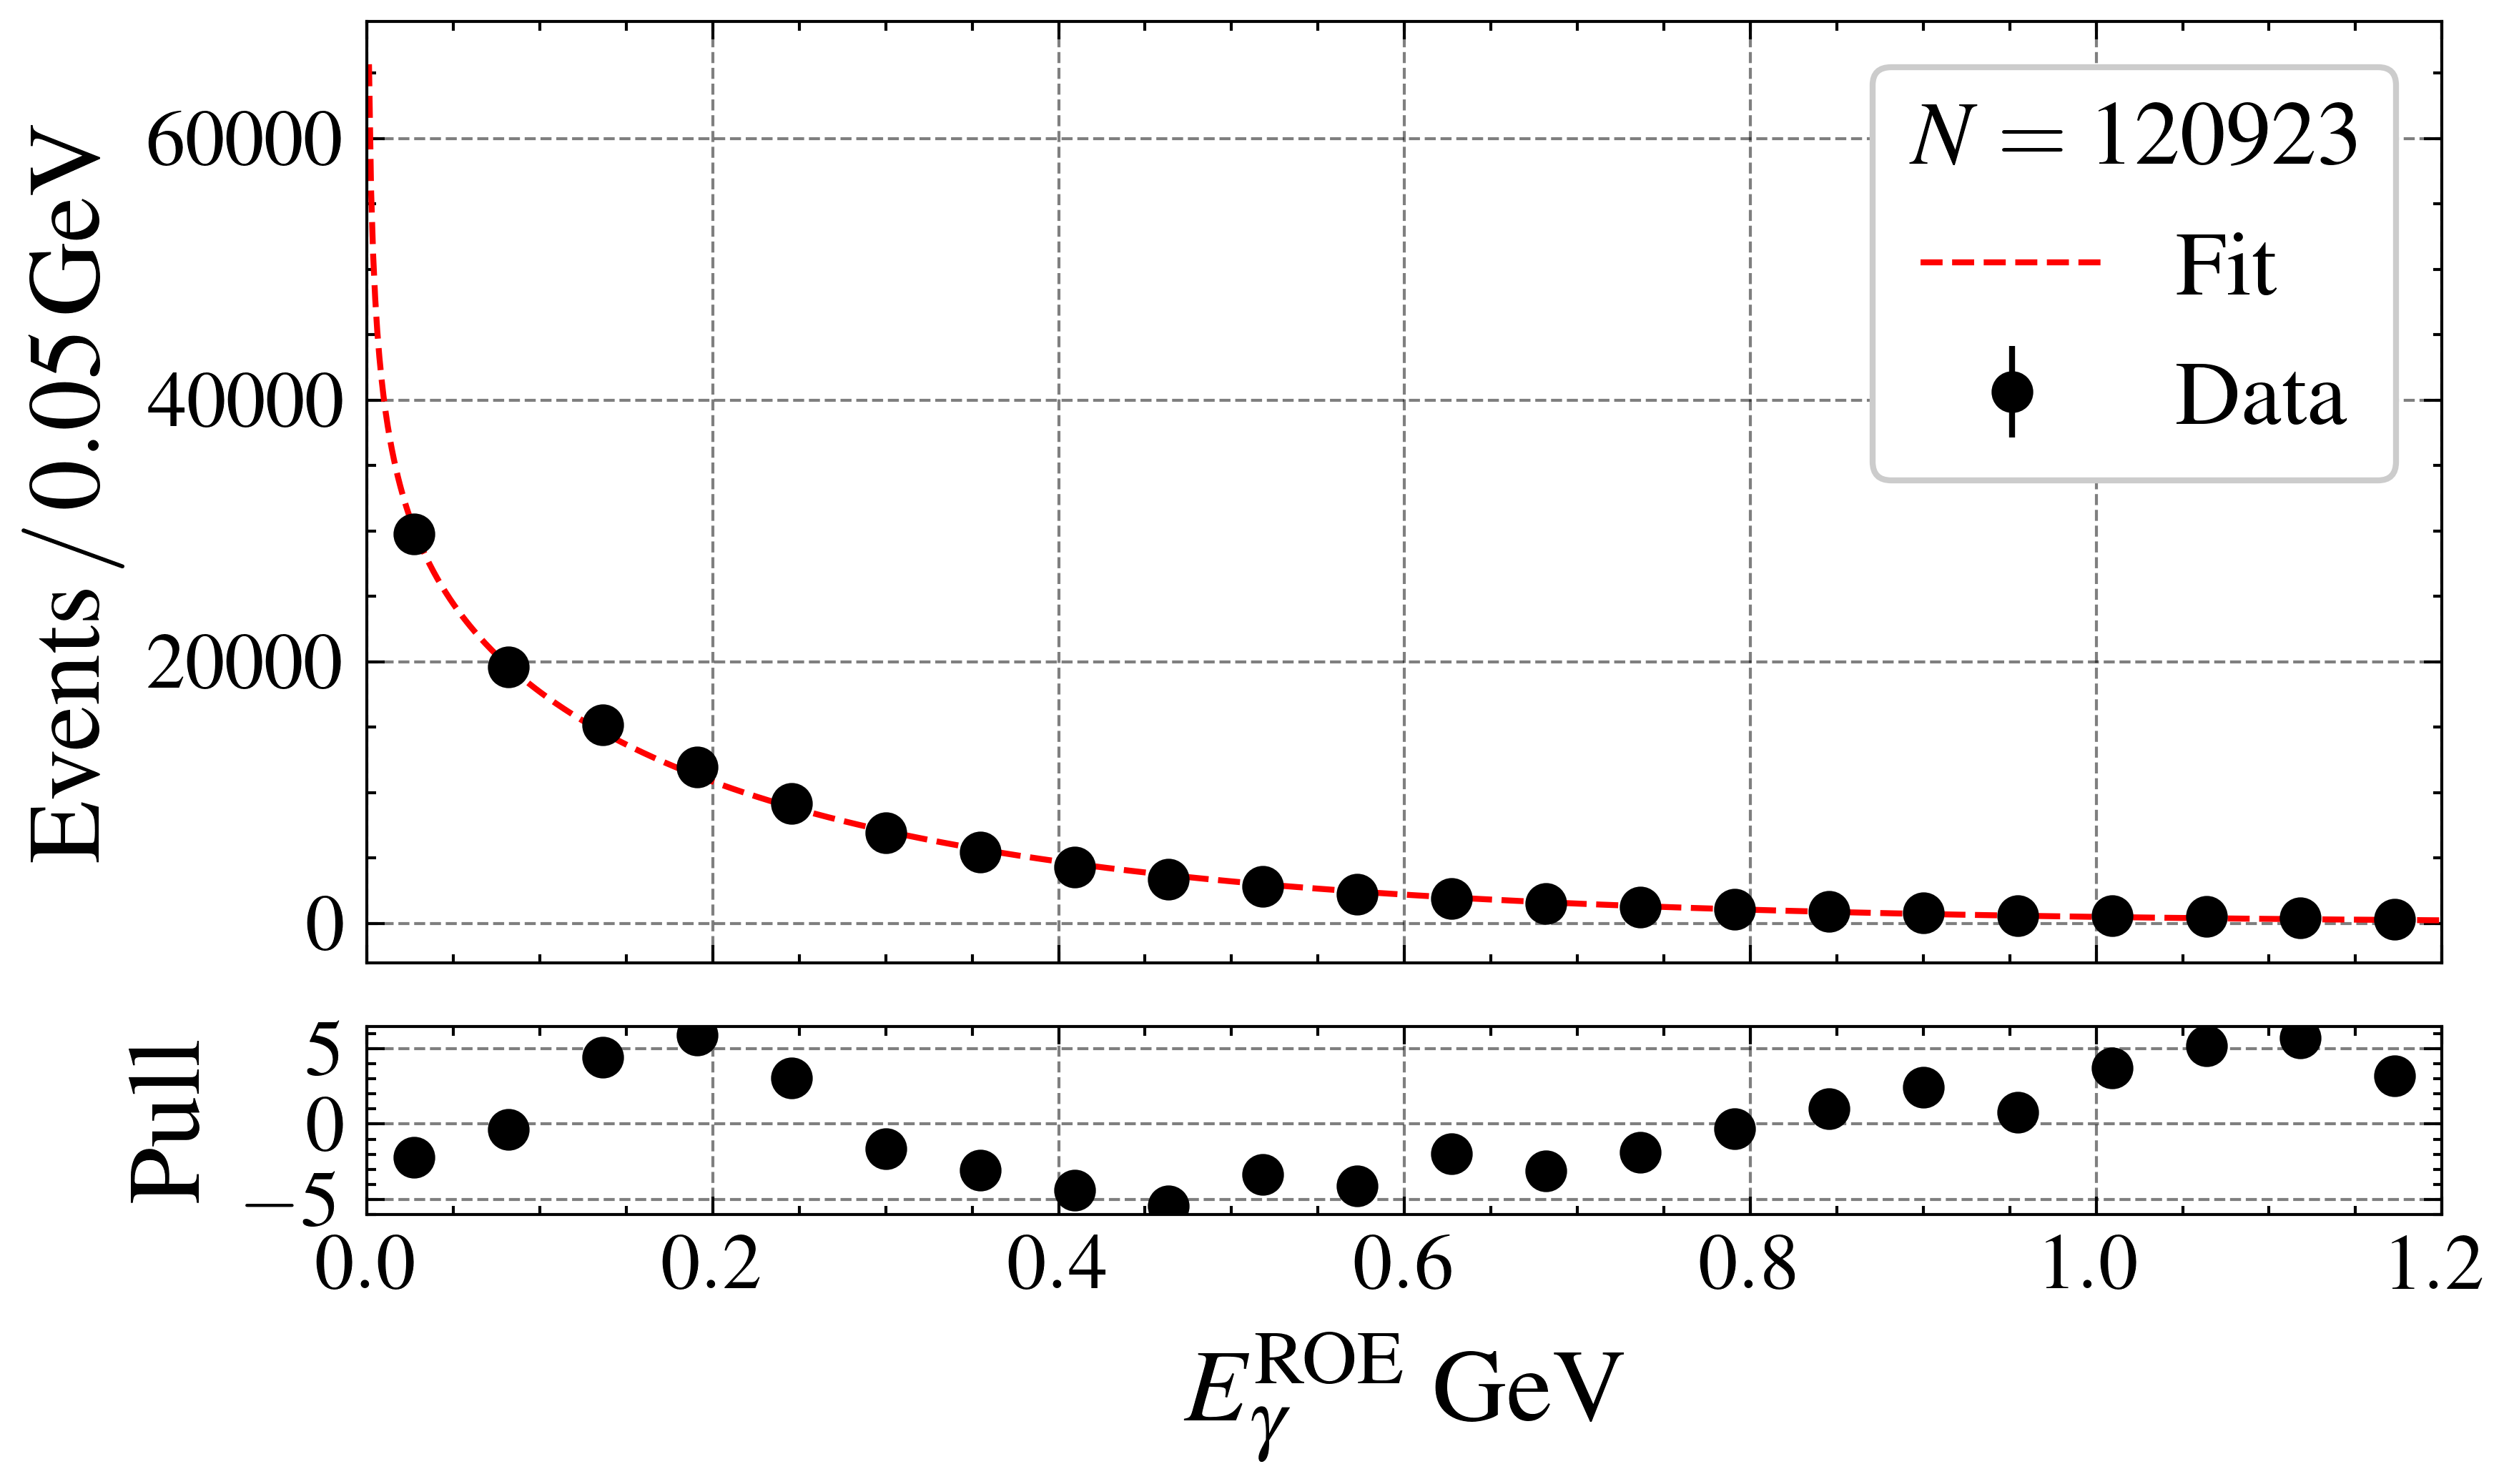

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(plt_s[0], plt_s[1]+pull_s[1]), gridspec_kw={'height_ratios': [1, 0.2]}, sharex=True)
ax = axs[0]
ax.errorbar(bin_centers, counts, yerr=0, fmt='o', label="Data")
ax.plot(np.linspace(a, b, 1000), pdf(np.linspace(a, b, 1000), **rez), label="Fit")
ax.set_ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}\\,\\mathrm{{GeV}}$')
ax.set_title("")
ax.set_xlim(a, b)
ax.legend(title=f"$N = {N}$")

ax_resid = axs[1]
residuals = counts - pdf(bin_centers, **rez)
ax_resid.plot(bin_centers, residuals / np.sqrt(counts), 'o')
ax_resid.set_xlabel(r'$E_{\gamma}^\mathrm{ROE} \ \mathrm{GeV}$')
ax_resid.set_ylabel('$\\mathrm{Pull}$')
ax_resid.set_xlim(ax.get_xlim()) 
plt.tight_layout()
plt.show()

In [31]:
wbin = 0.5
a = 0
b = 10
bins = np.linspace(a, b, int((b-a)/wbin))

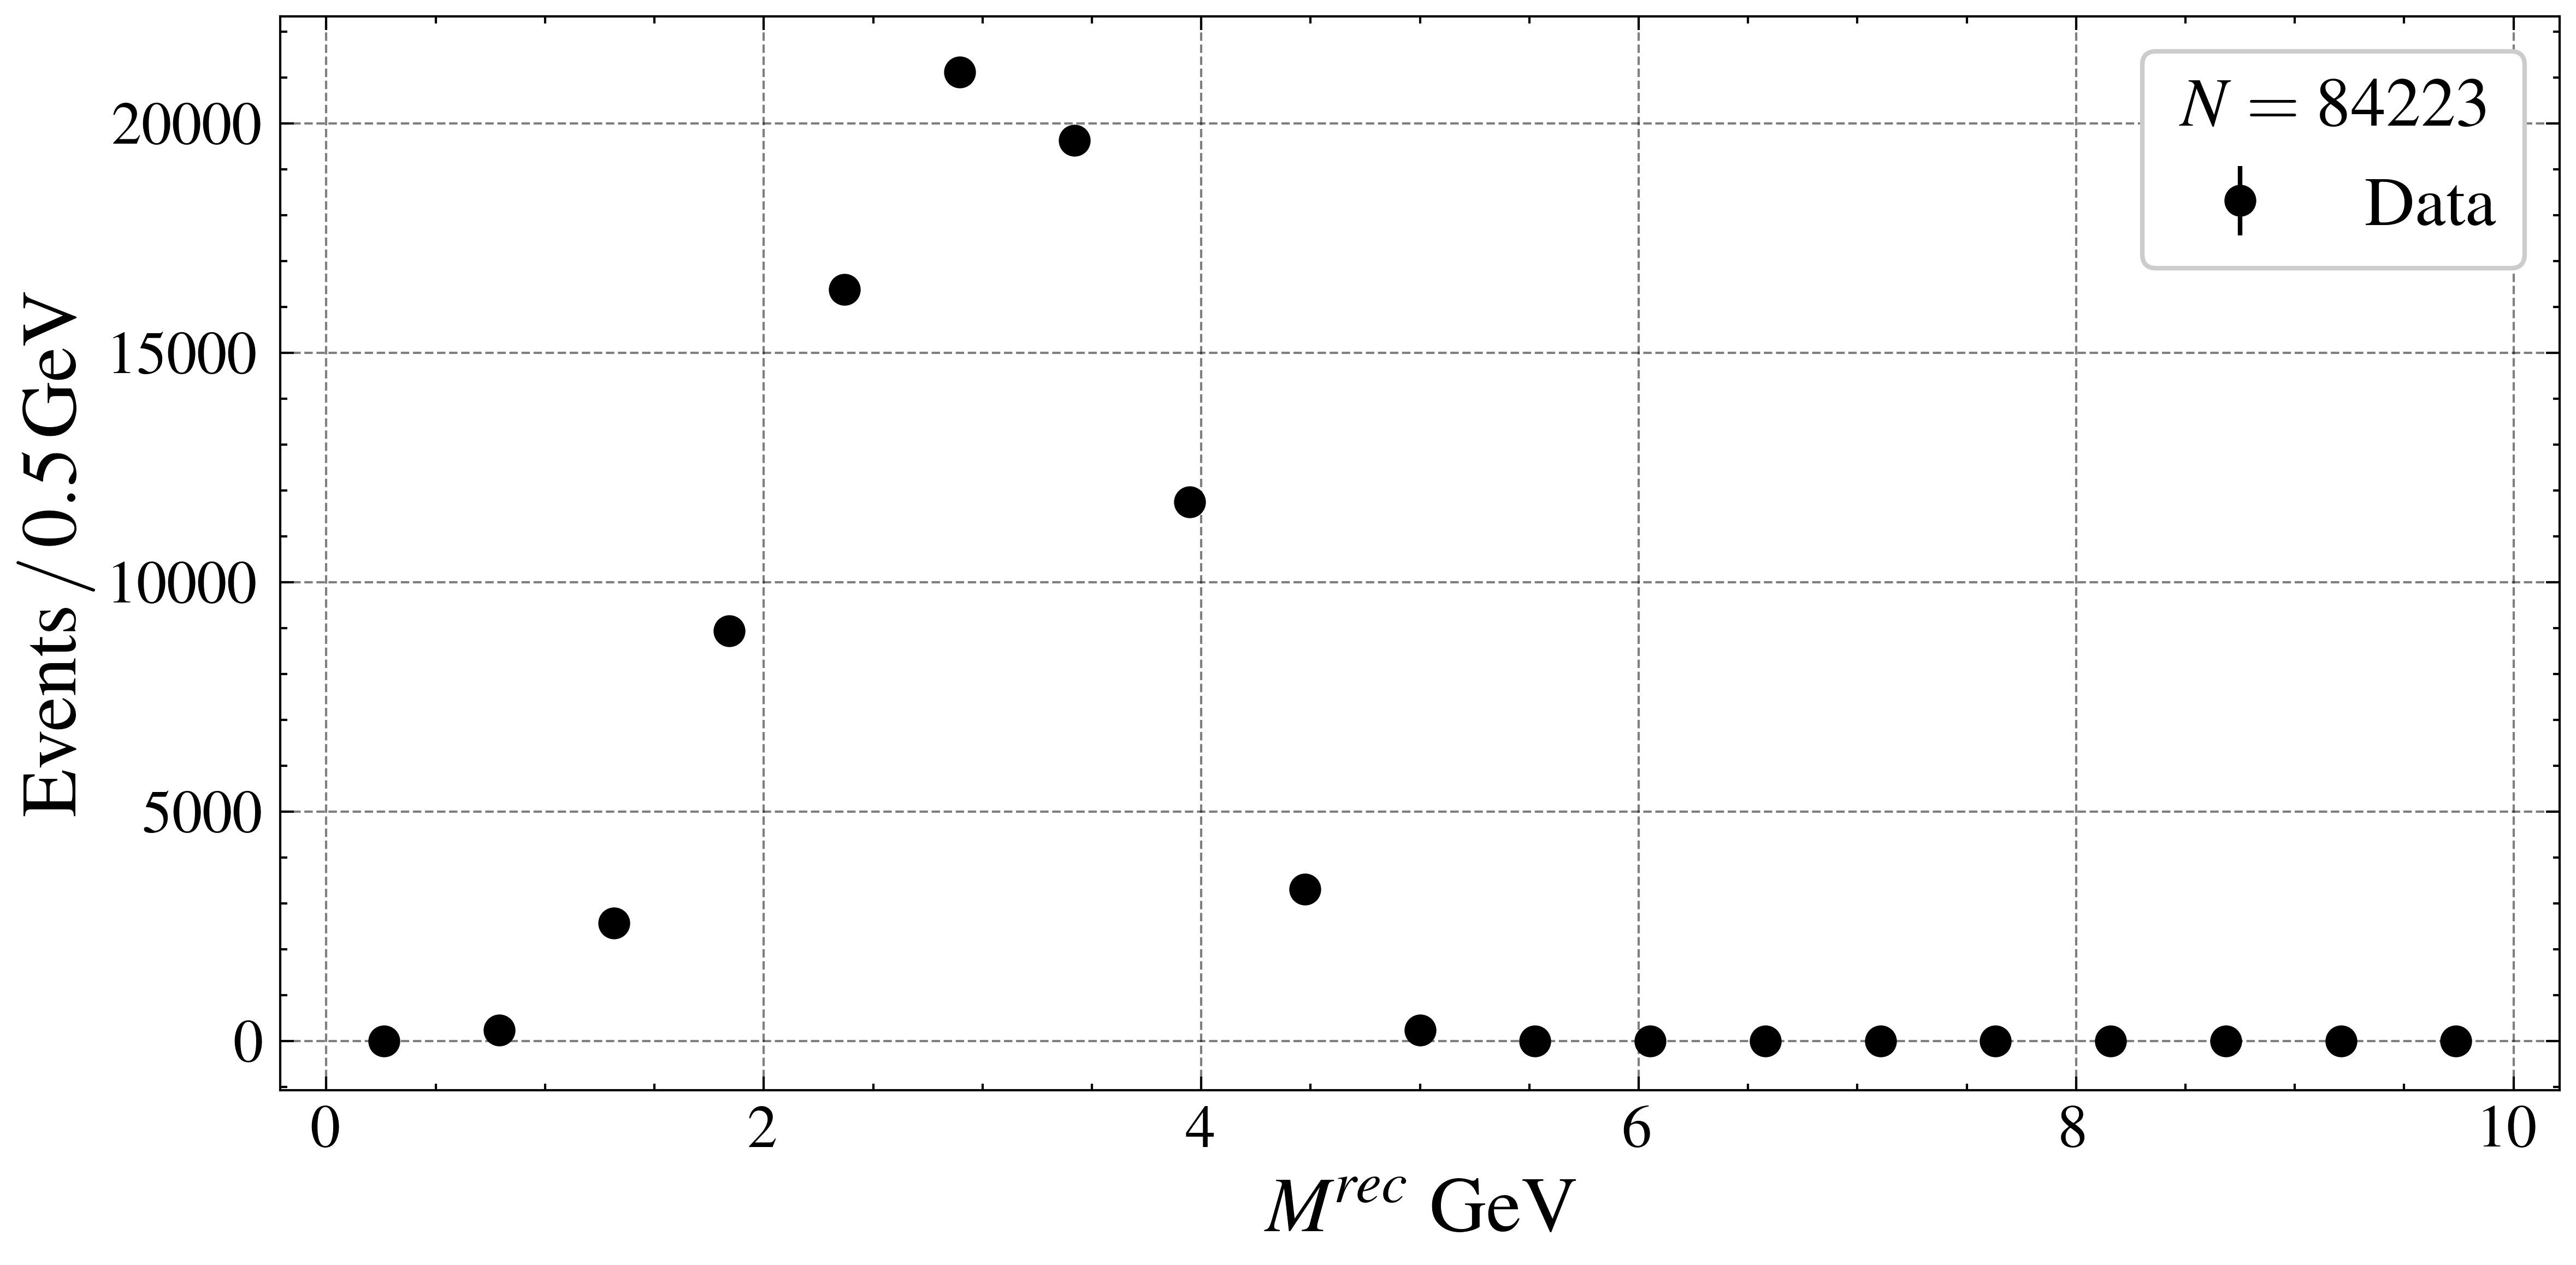

In [32]:
bin_centers, counts, N = compute_histogram(dataset, bins, "recM2_Ups", fun=lambda x : x**0.5, filter_mask = mask & ((pc.field("E_gamma_in_ROE") < 0.2)) & mask_lep & (pc.field("is0") == 1) & mask_is1)


fig, ax = plt.subplots(1, figsize=(12/1.5, 6/1.5))

ax.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='o', label="Data")
ax.set_ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}\\,\\mathrm{{GeV}}$')
ax.set_xlabel(r'$M^{rec} \ \mathrm{GeV}$')
ax.legend(title=f"$N = {N}$")

plt.tight_layout()
plt.show()

In [33]:
wbin = 0.5
a = 0
b = 10
bins = np.linspace(a, b, int((b-a)/wbin))

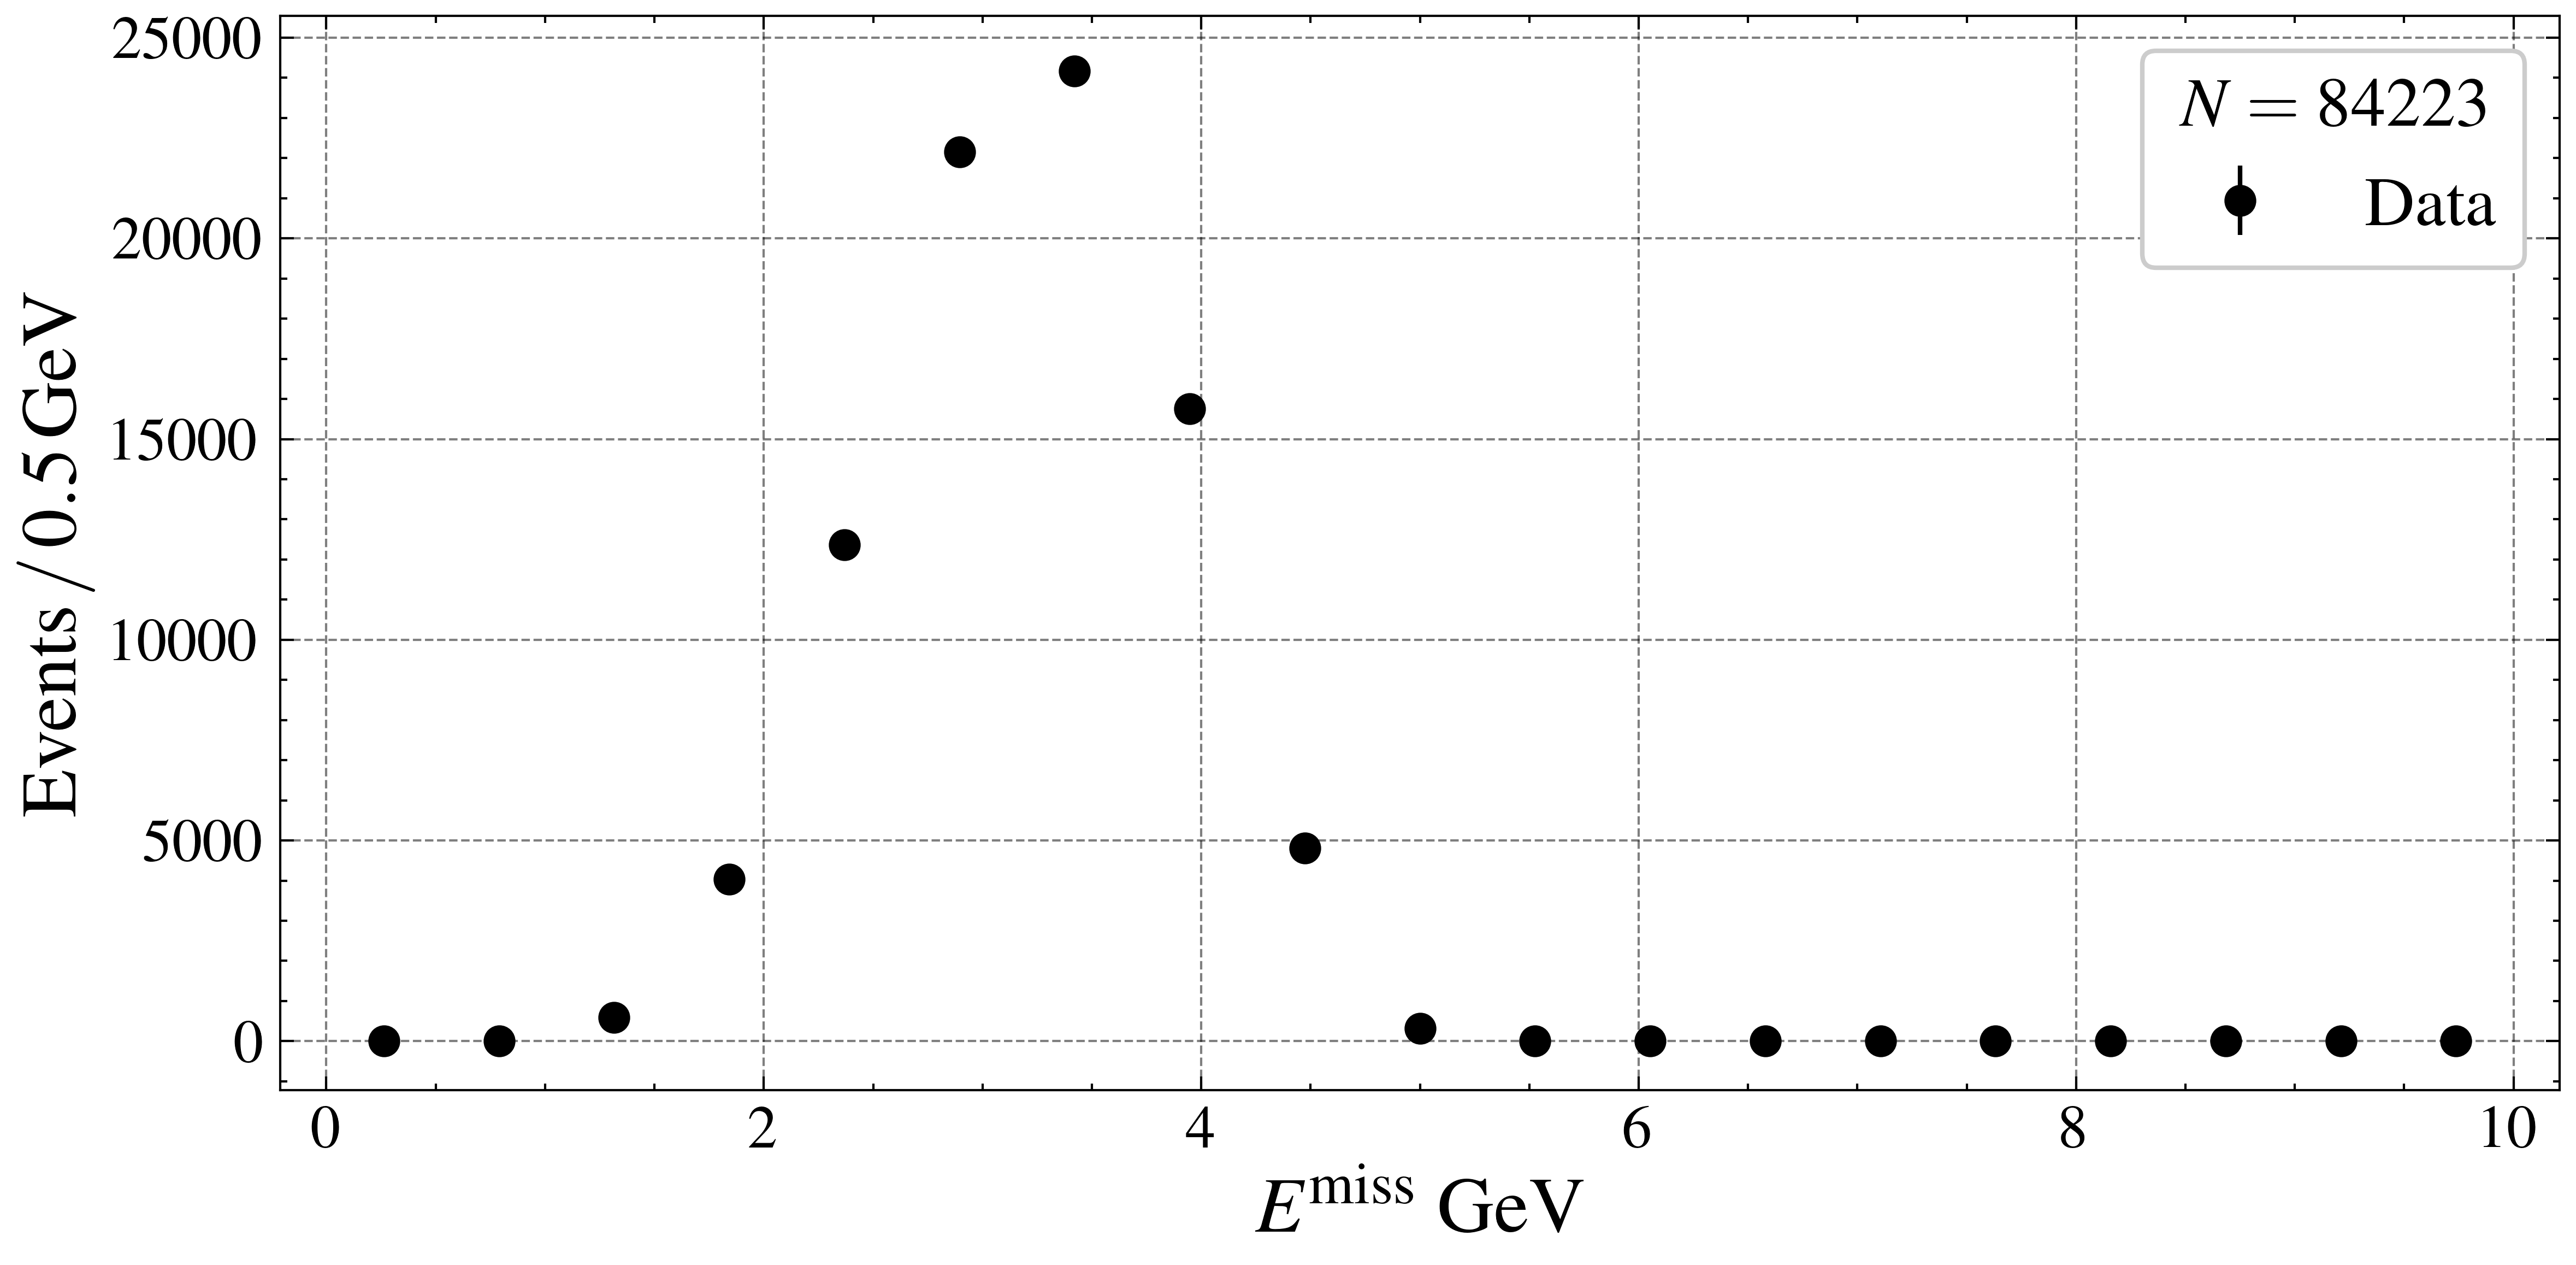

In [34]:
bin_centers, counts, N = compute_histogram(dataset, bins, "missedE", filter_mask = mask & ((pc.field("E_gamma_in_ROE") < 0.2)) & mask_lep & (pc.field("is0") == 1) & mask_is1)


fig, ax = plt.subplots(1, figsize=(12/1.5, 6/1.5))

ax.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='o', label="Data")
ax.set_ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}\\,\\mathrm{{GeV}}$')
ax.set_xlabel(r'$E^\mathrm{miss} \ \mathrm{GeV}$')
ax.legend(title=f"$N = {N}$")

plt.tight_layout()
plt.show()

In [48]:
wbin = 0.5
a = 28
b = 35
bins = np.linspace(a, b, int((b-a)/wbin))

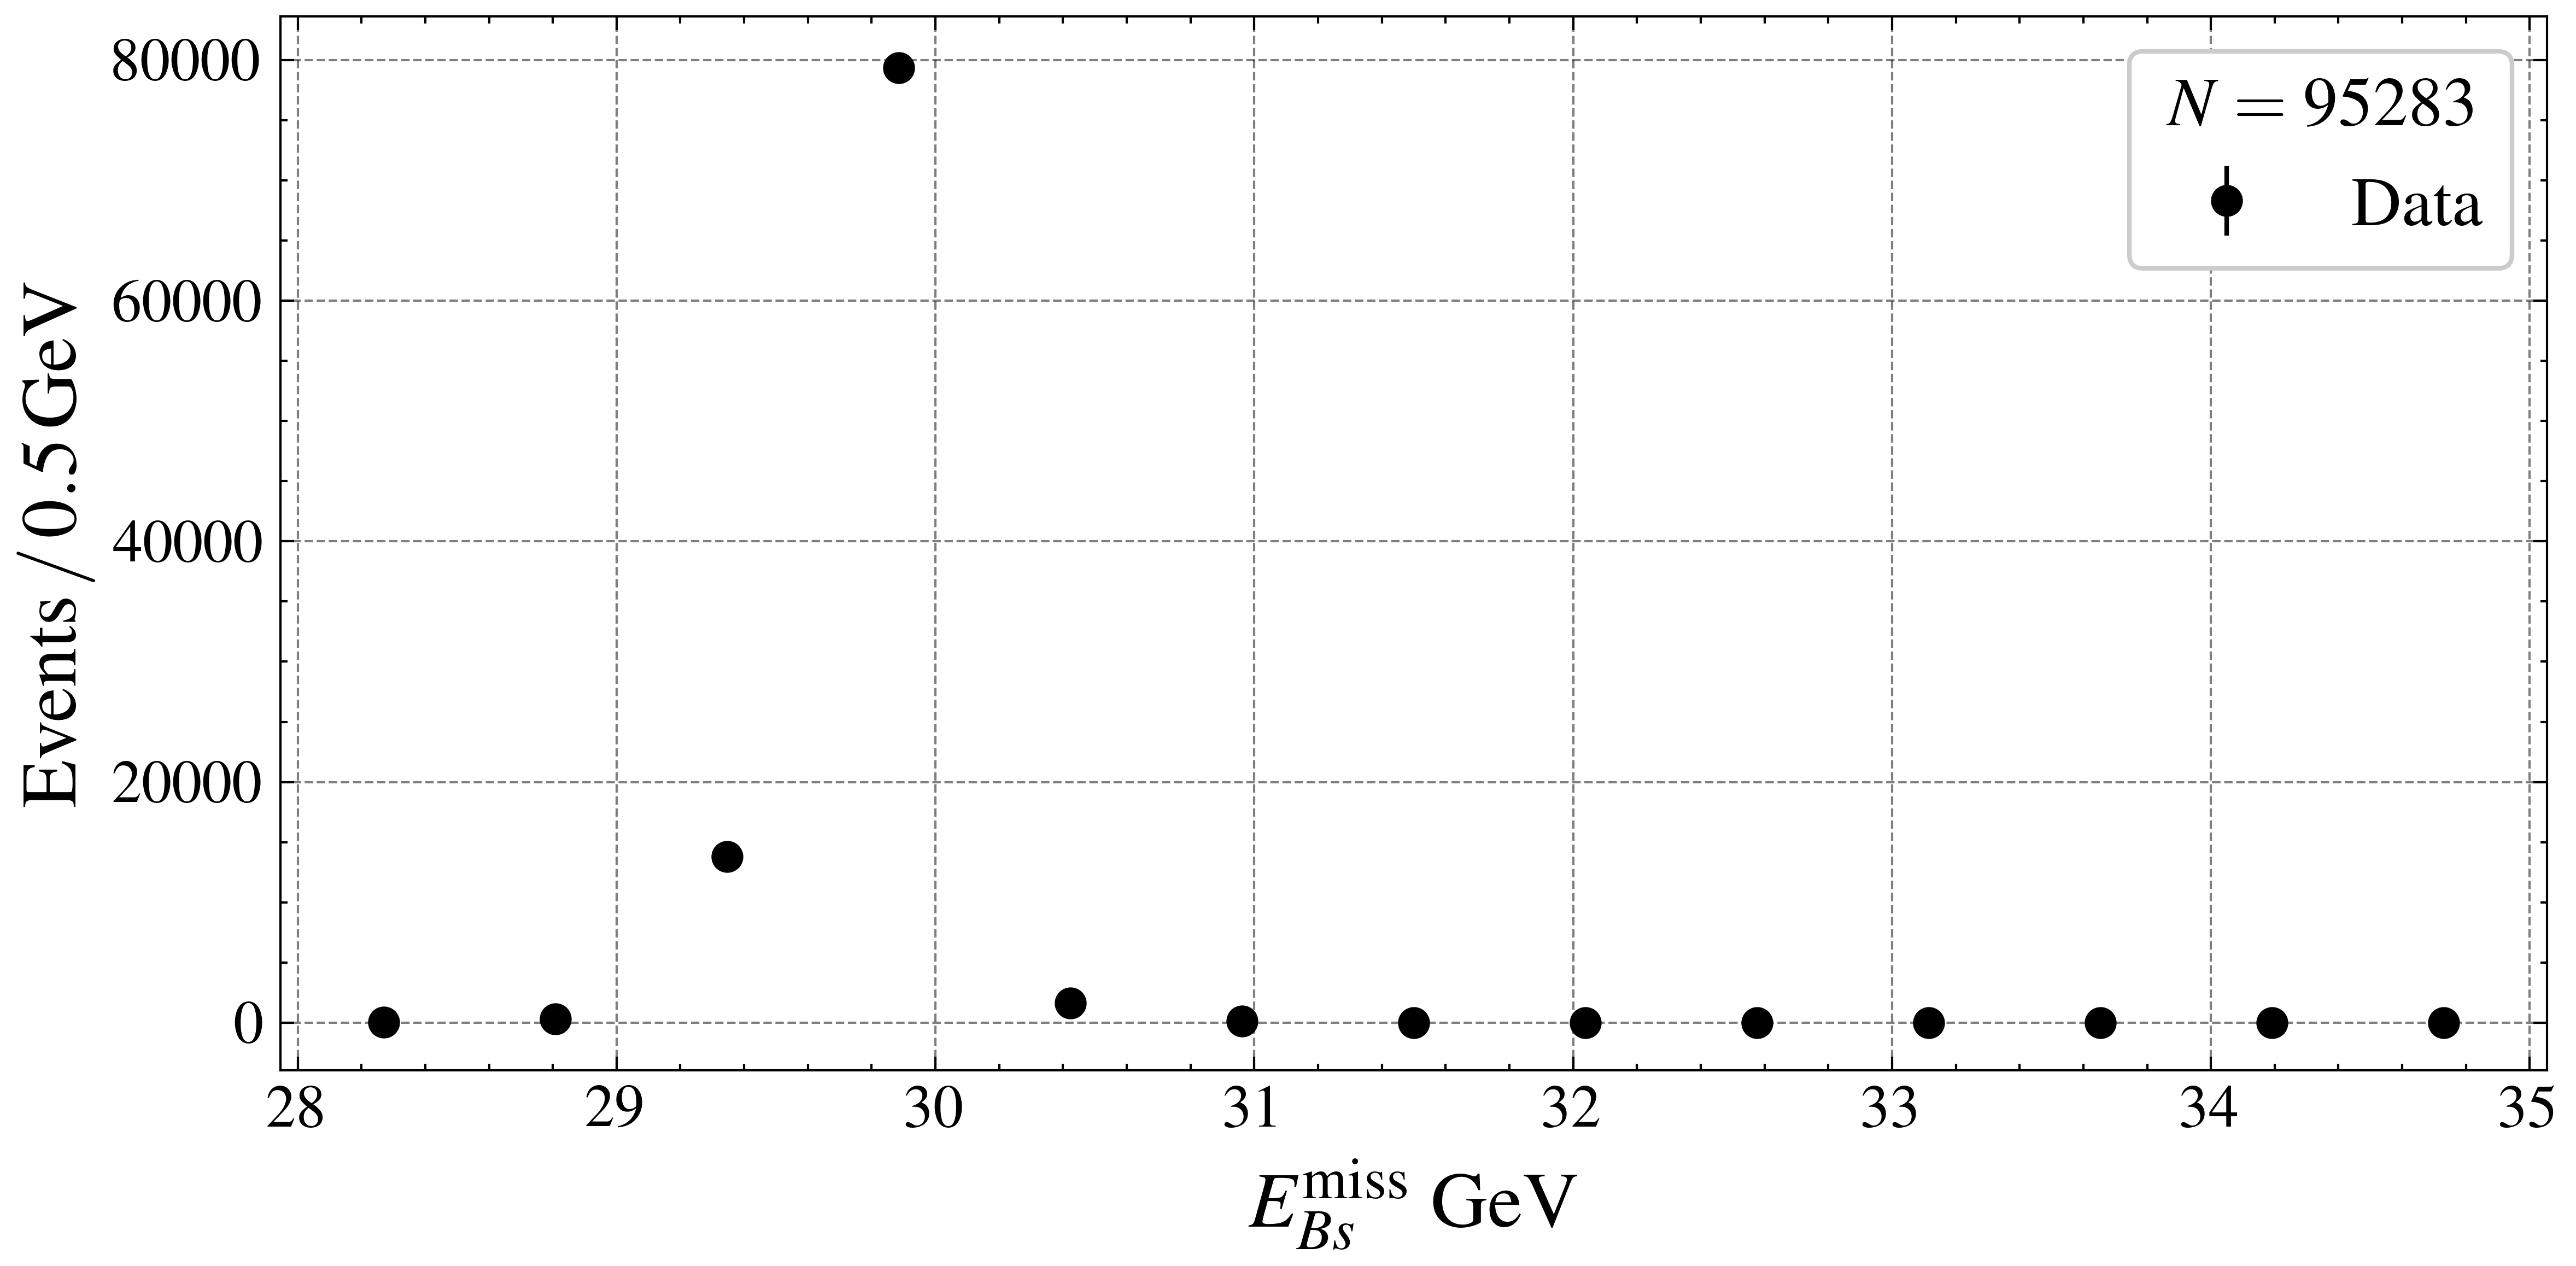

In [49]:
bin_centers, counts, N = compute_histogram(dataset, bins, "recM2_Bs", filter_mask = mask & ((pc.field("E_gamma_in_ROE") < 0.2)) & mask_lep & (pc.field("is0") == 1))

fig, ax = plt.subplots(1, figsize=(12/1.5, 6/1.5))

ax.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='o', label="Data")
ax.set_ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}\\,\\mathrm{{GeV}}$')
ax.set_xlabel(r'$E^\mathrm{miss}_{Bs} \ \mathrm{GeV}$')
ax.legend(title=f"$N = {N}$")

plt.tight_layout()


In [ ]:
bin_centers, counts, N = compute_histogram(dataset, bins, "pmiss", filter_mask = mask & ((pc.field("E_gamma_in_ROE") < 0.2)) & mask_lep & (pc.field("is0") == 1))

fig, ax = plt.subplots(1, figsize=(12/1.5, 6/1.5))

ax.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='o', label="Data")
ax.set_ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}\\,\\mathrm{{GeV}}$')
ax.set_xlabel(r'$p^\mathrm{miss} \ \mathrm{GeV}$')
ax.legend(title=f"$N = {N}$")

plt.tight_layout()


In [50]:
wbin = 0.5
a = 0
b = 1
bins = np.linspace(a, b, int((b-a)/wbin))

In [51]:
bin_centers, counts, N = compute_histogram(dataset, bins, "pmiss", filter_mask = mask & ((pc.field("E_gamma_in_ROE") < 0.2)) & mask_lep & (pc.field("is0") == 1))

fig, ax = plt.subplots(1, figsize=(12/1.5, 6/1.5))

ax.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='o', label="Data")
ax.set_ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}\\,\\mathrm{{GeV}}$')
ax.set_xlabel(r'$Fox $')
ax.legend(title=f"$N = {N}$")

plt.tight_layout()


KeyError: 'Field "pmiss" does not exist in schema'